<a href="https://colab.research.google.com/github/viveksingh19/DU_Competition/blob/master/Fashion_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
import torchvision
from tqdm import tqdm
from torchvision import datasets, models, transforms

In [2]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
batchsize = 64
lr = 0.001
epochs = 30

In [4]:
transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.485), (0.229))
])


dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)

trainset, validset = random_split(dataset, [55000, 5000])

testset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)

## Setting up dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
## Verifying shape of image and label
image, label = next(iter(trainloader))
image.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [6]:
## Training One Epoch
def trainOneEpoch(model, trainloader, optimizer, criterion):
  train_loss = 0
  train_acc = 0
  total = 0

  model.train()
  for image, label in tqdm(trainloader):
    image, label = image.to(device), label.to(device)
    
    output = model(image)
    loss = criterion(output, label)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, pred = torch.max(output, dim=1)
    train_acc += torch.sum(pred == label).item()
    total += label.size(0)
  
  ## Calculating Training Epoch loss and accuracy
  train_loss = round(float(train_loss/total), 5)
  train_acc  = round(float(train_acc/total), 5)
  
  return train_loss, train_acc

In [7]:
## Validation on Epoch
def validEpoch(model, validloader, criterion, scheduler):
  valid_loss = 0
  valid_acc = 0
  total = 0

  with torch.no_grad():
    model.eval()
    for image, label in validloader:
      image, label = image.to(device), label.to(device)
      
      output = model(image)
      loss = criterion(output, label)
      
      valid_loss += loss.item()
      _, pred = torch.max(output, dim=1)
      valid_acc += torch.sum(pred == label).item()
      total += label.size(0)

  scheduler.step(valid_loss)
  
  ## Calculating Validation Epoch loss and accuracy
  valid_loss = round(float(valid_loss/total), 4)
  valid_acc = round(float(valid_acc/total), 4)

  return valid_loss, valid_acc

In [9]:
## Training Model
def trainModel(model, trainloader, validloader, optimizer, criterion, scheduler, epochs):
  train_loss_list = []
  train_acc_list = []
  valid_loss_list = []
  valid_acc_list = []
  max_val_acc = 0

  print("Training started for model\n")
  for epoch in range(epochs):
    print(f"Epoch  ({epoch+1}/{epochs})")
    train_loss, train_acc = trainOneEpoch(model, trainloader, optimizer, criterion)
    print(f"Training Loss: {train_loss}, Training Accuracy: {train_acc}")
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    valid_loss, valid_acc = validEpoch(model, validloader, criterion, scheduler)
    print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    if max_val_acc <= valid_acc:
      max_val_acc = valid_acc
      print("Saving Best Model")
      torch.save(model.state_dict(), "bestModel.pt")
    print("-----------------------------\n")
  
  return model, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list


In [10]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding="same"),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32, 64, 3, padding="same"),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(64*7*7, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 10)
    )
  
  def forward(self, x):
    output = self.features(x)
    ## Flattening Tensor
    output = output.view(output.size(0), 64*7*7)
    output = self.classifier(output)
    return output

In [11]:
model = Model()
model = model.to(device)
## Softmax in included in the CrossEntropyLoss() in PyTorch
criterion = nn.CrossEntropyLoss()
## Using Adam with Default Parameters
optimizer = optim.Adam(model.parameters(), lr=lr)
## Setting up scheduler for when the validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)


In [12]:
model, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = trainModel(model, trainloader, validloader, optimizer, criterion, scheduler, epochs)

Training started for model

Epoch  (1/30)


  0%|          | 0/860 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 860/860 [01:03<00:00, 13.59it/s]


Training Loss: 0.007, Training Accuracy: 0.83675
Validation Loss: 0.0048, Validation Accuracy: 0.8944
Saving Best Model
-----------------------------

Epoch  (2/30)


100%|██████████| 860/860 [01:03<00:00, 13.57it/s]


Training Loss: 0.00479, Training Accuracy: 0.8866
Validation Loss: 0.0042, Validation Accuracy: 0.9034
Saving Best Model
-----------------------------

Epoch  (3/30)


100%|██████████| 860/860 [01:03<00:00, 13.58it/s]


Training Loss: 0.00421, Training Accuracy: 0.89985
Validation Loss: 0.0039, Validation Accuracy: 0.91
Saving Best Model
-----------------------------

Epoch  (4/30)


100%|██████████| 860/860 [01:02<00:00, 13.67it/s]


Training Loss: 0.00381, Training Accuracy: 0.90902
Validation Loss: 0.0039, Validation Accuracy: 0.9066
-----------------------------

Epoch  (5/30)


100%|██████████| 860/860 [01:02<00:00, 13.68it/s]


Training Loss: 0.0035, Training Accuracy: 0.91595
Validation Loss: 0.0036, Validation Accuracy: 0.918
Saving Best Model
-----------------------------

Epoch  (6/30)


100%|██████████| 860/860 [01:02<00:00, 13.75it/s]


Training Loss: 0.00328, Training Accuracy: 0.92162
Validation Loss: 0.0038, Validation Accuracy: 0.913
-----------------------------

Epoch  (7/30)


100%|██████████| 860/860 [01:01<00:00, 13.90it/s]


Training Loss: 0.00305, Training Accuracy: 0.92682
Validation Loss: 0.0034, Validation Accuracy: 0.9242
Saving Best Model
-----------------------------

Epoch  (8/30)


100%|██████████| 860/860 [01:01<00:00, 13.97it/s]


Training Loss: 0.00287, Training Accuracy: 0.93089
Validation Loss: 0.0034, Validation Accuracy: 0.921
-----------------------------

Epoch  (9/30)


100%|██████████| 860/860 [01:01<00:00, 14.00it/s]


Training Loss: 0.00273, Training Accuracy: 0.93333
Validation Loss: 0.0033, Validation Accuracy: 0.924
-----------------------------

Epoch  (10/30)


100%|██████████| 860/860 [01:00<00:00, 14.17it/s]


Training Loss: 0.00252, Training Accuracy: 0.93935
Validation Loss: 0.0036, Validation Accuracy: 0.9198
-----------------------------

Epoch  (11/30)


100%|██████████| 860/860 [01:00<00:00, 14.14it/s]


Training Loss: 0.00244, Training Accuracy: 0.94153
Validation Loss: 0.0036, Validation Accuracy: 0.918
-----------------------------

Epoch  (12/30)


100%|██████████| 860/860 [01:01<00:00, 14.05it/s]


Training Loss: 0.00229, Training Accuracy: 0.94458
Validation Loss: 0.0034, Validation Accuracy: 0.921
-----------------------------

Epoch  (13/30)


100%|██████████| 860/860 [01:01<00:00, 13.95it/s]


Training Loss: 0.00219, Training Accuracy: 0.94676
Validation Loss: 0.0036, Validation Accuracy: 0.9226
-----------------------------

Epoch  (14/30)


100%|██████████| 860/860 [01:01<00:00, 14.09it/s]


Training Loss: 0.0021, Training Accuracy: 0.9496
Validation Loss: 0.0036, Validation Accuracy: 0.9224
-----------------------------

Epoch  (15/30)


100%|██████████| 860/860 [01:00<00:00, 14.21it/s]


Training Loss: 0.00205, Training Accuracy: 0.95029
Validation Loss: 0.0037, Validation Accuracy: 0.9174
-----------------------------

Epoch  (16/30)


100%|██████████| 860/860 [01:00<00:00, 14.14it/s]


Training Loss: 0.00159, Training Accuracy: 0.96256
Validation Loss: 0.0034, Validation Accuracy: 0.9274
Saving Best Model
-----------------------------

Epoch  (17/30)


100%|██████████| 860/860 [01:01<00:00, 14.05it/s]


Training Loss: 0.00149, Training Accuracy: 0.96438
Validation Loss: 0.0035, Validation Accuracy: 0.9288
Saving Best Model
-----------------------------

Epoch  (18/30)


100%|██████████| 860/860 [01:01<00:00, 14.02it/s]


Training Loss: 0.00139, Training Accuracy: 0.96685
Validation Loss: 0.0035, Validation Accuracy: 0.9298
Saving Best Model
-----------------------------

Epoch  (19/30)


100%|██████████| 860/860 [01:01<00:00, 13.96it/s]


Training Loss: 0.00139, Training Accuracy: 0.96664
Validation Loss: 0.0035, Validation Accuracy: 0.9302
Saving Best Model
-----------------------------

Epoch  (20/30)


100%|██████████| 860/860 [01:00<00:00, 14.13it/s]


Training Loss: 0.00132, Training Accuracy: 0.96782
Validation Loss: 0.0034, Validation Accuracy: 0.9308
Saving Best Model
-----------------------------

Epoch  (21/30)


100%|██████████| 860/860 [01:01<00:00, 14.09it/s]


Training Loss: 0.00133, Training Accuracy: 0.96795
Validation Loss: 0.0035, Validation Accuracy: 0.9284
-----------------------------

Epoch  (22/30)


100%|██████████| 860/860 [01:00<00:00, 14.15it/s]


Training Loss: 0.00127, Training Accuracy: 0.96918
Validation Loss: 0.0034, Validation Accuracy: 0.9306
-----------------------------

Epoch  (23/30)


100%|██████████| 860/860 [01:00<00:00, 14.21it/s]


Training Loss: 0.00125, Training Accuracy: 0.96938
Validation Loss: 0.0035, Validation Accuracy: 0.9304
-----------------------------

Epoch  (24/30)


100%|██████████| 860/860 [01:00<00:00, 14.13it/s]


Training Loss: 0.00125, Training Accuracy: 0.97011
Validation Loss: 0.0035, Validation Accuracy: 0.931
Saving Best Model
-----------------------------

Epoch  (25/30)


100%|██████████| 860/860 [01:00<00:00, 14.14it/s]


Training Loss: 0.00121, Training Accuracy: 0.97085
Validation Loss: 0.0035, Validation Accuracy: 0.9308
-----------------------------

Epoch  (26/30)


100%|██████████| 860/860 [01:00<00:00, 14.21it/s]


Training Loss: 0.00122, Training Accuracy: 0.97018
Validation Loss: 0.0035, Validation Accuracy: 0.9306
-----------------------------

Epoch  (27/30)


100%|██████████| 860/860 [01:01<00:00, 14.07it/s]


Training Loss: 0.00123, Training Accuracy: 0.97051
Validation Loss: 0.0035, Validation Accuracy: 0.9306
-----------------------------

Epoch  (28/30)


100%|██████████| 860/860 [01:00<00:00, 14.17it/s]


Training Loss: 0.0012, Training Accuracy: 0.97144
Validation Loss: 0.0035, Validation Accuracy: 0.931
Saving Best Model
-----------------------------

Epoch  (29/30)


100%|██████████| 860/860 [01:01<00:00, 14.02it/s]


Training Loss: 0.00121, Training Accuracy: 0.97104
Validation Loss: 0.0035, Validation Accuracy: 0.931
Saving Best Model
-----------------------------

Epoch  (30/30)


100%|██████████| 860/860 [01:00<00:00, 14.16it/s]


Training Loss: 0.00122, Training Accuracy: 0.97096
Validation Loss: 0.0035, Validation Accuracy: 0.931
Saving Best Model
-----------------------------



In [13]:
import matplotlib.pyplot as plt

In [17]:
def plotCurve(train, valid, task):
    plt.plot(train)
    plt.plot(valid)
    plt.title(f'Model {task}')
    plt.ylabel(task)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'])
    plt.show()

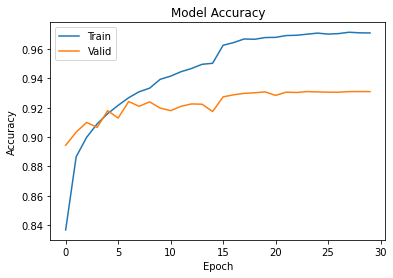

In [18]:
## Plotting accuracy curve
plotCurve(train_acc_list, valid_acc_list, "Accuracy")

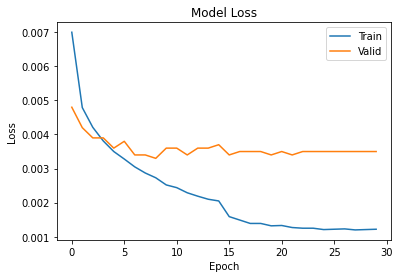

In [19]:
## Plotting loss curve
plotCurve(train_loss_list, valid_loss_list, "Loss")

In [20]:
accuracy = 0
total = 0
for image, label in testloader:
  image, label = image.to(device), label.to(device)
  output = model(image)
  _, pred = torch.max(output, dim=1)
  accuracy += torch.sum(pred == label)/len(pred)
  total += 1

accuracy /= total
print(f"TEST ACCURACY: {round(accuracy.item()*100,2)}%")

TEST ACCURACY: 93.35%
